# Preparation for Milestone Four

Today, we will begin preparing for the final milestone. Here, we will assemble all the pieces of the pipeline you've created. You will need to write a function **compute_AgNOR_score**. This function first utilizes the detection model to locate cells within a given image and then feeds those cells into a classification model to classify them into one of the AgNOR classes. Finally, you will aggregate all predictions into a final AgNOR score for the entire image.

In [1]:
#define detection model
import torch
import torchvision
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import MobileNet_V2_Weights

def load_detection_model(path_to_weights: str):
    device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
    backbone = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).features
    backbone.out_channels = 1280
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    model = RetinaNet(backbone,
                      num_classes=2,
                      anchor_generator=anchor_generator)
    
    # Load the model weights with map_location
    model.load_state_dict(torch.load(path_to_weights, map_location=device))
    model.eval()
    return model

path_to_weights = 'retinanet/best_model_0.743_map.pth'

# device mps
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

detection_model = load_detection_model(path_to_weights).to(device)
print(detection_model)


mps
RetinaNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, ep

In [2]:
# define classfication model

import torch
import torchvision.models as models
from torch import nn

def load_classification_model(path_to_weights: str):
    device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
    # Load the model
    model = models.efficientnet_b0(weights=None)
    model.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=12)  # Assuming binary classification
    )
    model.load_state_dict(torch.load(path_to_weights, map_location=device))
    model.eval()
    return model.to(device)

classification_model_path = '/Users/fatihozkan/Desktop/Semester_4/semester_4_new/Computer_Vision/Milestones/2.second milestone/best_model.pth'
classification_model = load_classification_model(classification_model_path).to(device)
print(classification_model)



EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# 1. Write a function "process_image" which receives an image and runs the detection model on it.

The function should have the following parameters:

1. image: The image on which you want to run inference.
2. crop_size: The size of the crops you want to load from the image.
3. overlap: Percentage or number of pixels the crops should overlap.
4. model: The object detection model. This function should generally be able to run with any detection model.
5. detection_threshold: A threshold to apply to the detections to reject false positives.

The function will have to tile the image into **overlapping crops** and then feed each crop to the model. After that, all detections have to be transformed to the global coordinate system of the image since the detections are within the coordinate system of the image crop. Subsequently, [non-maximal suppression](https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html) needs to be applied to the detections in order to reject overlapping detections. In the end, the function will return the coordinates and scores of the detected cells that exceed the given threshold. Use **torch_no_grad** to save computation time and also ensure your **model is in evaluation mode** before feeding the cells to it.

[{'boxes': tensor([419.6068, 646.4150, 438.4285, 667.5150], device='mps:0'), 'scores': tensor(0.6401, device='mps:0')}, {'boxes': tensor([1053.5012,   41.0717, 1077.0864,   62.0022], device='mps:0'), 'scores': tensor(0.6126, device='mps:0')}, {'boxes': tensor([  30.0377, 1140.7321,   52.0894, 1162.4437], device='mps:0'), 'scores': tensor(0.6086, device='mps:0')}, {'boxes': tensor([831.2311, 782.4152, 853.6953, 804.2141], device='mps:0'), 'scores': tensor(0.5799, device='mps:0')}, {'boxes': tensor([736.7681, 358.4766, 756.2792, 378.7538], device='mps:0'), 'scores': tensor(0.5397, device='mps:0')}, {'boxes': tensor([1050.2670,  372.0952, 1072.2740,  396.6354], device='mps:0'), 'scores': tensor(0.5312, device='mps:0')}, {'boxes': tensor([450.8275, 648.9233, 472.5404, 672.5350], device='mps:0'), 'scores': tensor(0.5231, device='mps:0')}, {'boxes': tensor([348.0000, 177.4754, 368.1639, 198.5204], device='mps:0'), 'scores': tensor(0.5191, device='mps:0')}, {'boxes': tensor([1341.6208,  211.1

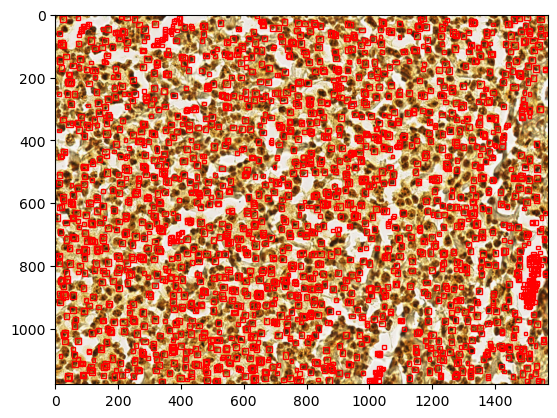

<Figure size 2000x2000 with 0 Axes>

In [21]:
import torch
import torchvision.transforms as T
import torchvision.ops as ops
from PIL import Image

def get_model_device(model):
    return next(model.parameters()).device

def process_image(image, crop_size, overlap, model, detection_threshold):
    """
    overlap: Overlap in pixels or percentage (0-1) of the crops.
    model: The object detection model.
    detection_threshold: Threshold to apply to the detections to reject false positives.
    Returns:
§§  List of dictionaries with 'boxes' and 'scores' for the detected objects.
    """
    model.eval()  # Set the model to evaluation mode
    device = get_model_device(model) # Get the device of the model

    if isinstance(overlap, float) and 0 <= overlap <= 1:
        overlap = (int(crop_size[0] * overlap), int(crop_size[1] * overlap))

    crop_width, crop_height = crop_size 
    overlap_width, overlap_height = overlap 
    
    image_width, image_height = image.size # Get the image size

    transform = T.ToTensor() # Transform to tensor

    detections = [] # List to store the detections

    with torch.no_grad():
        for x in range(0, image_width, crop_width - overlap_width):
            for y in range(0, image_height, crop_height - overlap_height):
                # Ensure the crop does not go out of the image boundaries
                crop_x2 = min(x + crop_width, image_width)
                crop_y2 = min(y + crop_height, image_height)
                crop_x1 = max(0, crop_x2 - crop_width)
                crop_y1 = max(0, crop_y2 - crop_height)
                
                crop = image.crop((crop_x1, crop_y1, crop_x2, crop_y2)).convert("RGB")
                
                # Convert the crop to a tensor and add batch dimension
                crop_tensor = transform(crop).unsqueeze(0).to(device)
                
                # Run the detection model on the croped image
                output = model(crop_tensor)[0]
                
                # # Debugging output
                # print(f"Crop coordinates: ({crop_x1}, {crop_y1}, {crop_x2}, {crop_y2})")
                # print(f"Output: {output}")

                # Filter detections by threshold
                for box, score in zip(output['boxes'], output['scores']):
                    if score > detection_threshold:
                        # Adjust the box coordinates to the global image coordinates
                        box[0] += crop_x1
                        box[1] += crop_y1
                        box[2] += crop_x1
                        box[3] += crop_y1
                        detections.append({'boxes': box, 'scores': score})

                        # # Debugging output
                        # print(f"Box: {box}, Score: {score}")

    if not detections:
        print("No detections found.")
        return []

    # Gather all boxes and scores
    all_boxes = torch.stack([d['boxes'] for d in detections]).to(device) # Convert to tensor and move to device, stack is for concatenating the boxes
    all_scores = torch.tensor([d['scores'] for d in detections]).to(device) 
    
    # Apply non-maximal suppression
    # this do the nms for all boxes and scores , nms is non-maximal suppression and it is used to remove the overlapping boxes
    nms_indices = ops.nms(all_boxes, all_scores, iou_threshold=0.5)
    
    # Gather the final detections
    final_detections = [{'boxes': all_boxes[i], 'scores': all_scores[i]} for i in nms_indices]
    
    return final_detections

# test the process_image function
image_path = 'data/AgNORs/AgNOR_0479.tiff'
image = Image.open(image_path)
detections = process_image(image, (128, 128), 0.1, detection_model, 0.1)
print(detections)

# Visualize the detections
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(image, detections):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for detection in detections:
        box = detection['boxes'].cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

plot_detections(image, detections)





# 2. Write a function "process_cells" which classifies the cells from the coordinates that were given to the model.

The function should have the following parameters:

1. image: The image from which to load the cells.
2. coords: Coordinates of the cells which you found with the detection algorithm.
3. model: The trained classification model.
4. crop_size: A size to resize the crops to. It should be equal to the size with which you trained the classification network.

The function should load each cell from the respective image and feed them to the classification model. Save the prediction and, in the end, aggregate the classifications of all cells into a final AgNOR score. The function should return the labels of the respective cells as well as the final AgNOR score.

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 

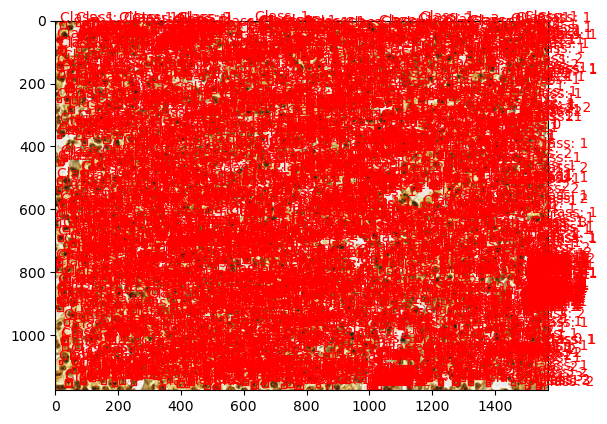

In [23]:
import torchvision.transforms as transforms
# classfiy cells 
def process_cells(image, coords, model, crop_size):
    """
    coords: detected cells from the detection algorithm.
    model:classification model.
    crop:Crops to for classification.

    Returns:
    - labels: Predicted labels for each cell.
    - agnor_score
    """
    model.eval()  # Set the model to evaluation mode
    device = get_model_device(model) # Get the device of the model
    
    # Transform to tensor and resize
    transform = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor()
    ])
    
    labels = [] # List to store the predicted labels
    
    with torch.no_grad(): # Disable gradient tracking for efficiency
        for coord in coords: # Iterate over the detected cells
            box = coord['boxes'].cpu().numpy()
            crop = image.crop((box[0], box[1], box[2], box[3])).convert("RGB") # Crop the cell and convert to RGB 
            crop_tensor = transform(crop).unsqueeze(0).to(device) # Convert to tensor and add batch dimension
            

            # Classify the crop
            output = model(crop_tensor) # Forward pass to the classification model i already trained for milestone2
            _, predicted = torch.max(output, 1) # Get the predicted class index, 
            labels.append(predicted.item())
    
    # i have 12 classes so i will calculate the agnor score by summing the labels and dividing by the length of the labels
    # this will give me the agnor score and it means the number of agnor cells in the image
    agnor_score = sum(labels) / len(labels)
    
    return labels, agnor_score

# Test the process_cells function
crop_size = (128, 128)
labels, agnor_score = process_cells(image, detections, classification_model, crop_size)
print(labels, agnor_score)

# Visualize the classification results
def plot_classification(image, detections, labels):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for detection, label in zip(detections, labels):
        box = detection['boxes'].cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f"Class: {label}", color='r')
    plt.show()

plot_classification(image, detections, labels)



# 3. Combine both functions into the function **compute_AgNOR_score**.

This function should receive the image as a parameter and also require all parameters to execute the subfunctions. In the end, this function should return the overall AgNOR score of the image.

In [25]:
def compute_AgNOR_score(image_path, detection_model_path, classification_model, detection_crop_size, classification_crop_size, detection_overlap, detection_threshold):
    image = Image.open(image_path).convert("RGB") # Open the image and convert to RGB
    detection_model = load_detection_model(detection_model_path) # Load the detection model
    detections = process_image(image, detection_crop_size, detection_overlap, detection_model, detection_threshold) # Detect the cells
    labels, agnor_score = process_cells(image, detections, classification_model, classification_crop_size) # Classify the cells
    return agnor_score # Return the AgNOR score

# Test the compute_AgNOR_score function
image_path = 'data/AgNORs/AgNOR_0479.tiff'
detection_model_path = 'retinanet/best_model_0.743_map.pth'
classification_model = load_classification_model(classification_model_path)
detection_crop_size = (128, 128)
classification_crop_size = (128, 128)
detection_overlap = 0.1
detection_threshold = 0.1

agnor_score = compute_AgNOR_score(image_path, detection_model_path, classification_model, detection_crop_size, classification_crop_size, detection_overlap, detection_threshold)
print(agnor_score)



1.1944042450554753


# 4. Test your pipeline.

Take several images (approximately 5) and run them through your pipeline. Then, calculate the error between the predicted AgNOR score and the AgNOR score defined by the labels of the cells in the annotation file. To obtain this label, simply calculate the mean of the labels of the respective image.

In [8]:
import pandas as pd

# Load the annotation file
annotations_path = 'annotation_frame.csv'
annotations = pd.read_csv(annotations_path)

# Display the first few rows of the annotations
annotations.head()


,filename,max_x,max_y,min_x,min_y,label
0,AgNOR_0495.tiff,26,41,4,15,1
1,AgNOR_0495.tiff,71,23,42,0,2
2,AgNOR_0495.tiff,133,61,104,37,1
3,AgNOR_0495.tiff,143,117,121,88,2
4,AgNOR_0495.tiff,224,37,199,12,1


In [26]:
import os
import torch
from PIL import Image
import pandas as pd

detection_model = load_detection_model(detection_model_path)
classification_model = load_classification_model(classification_model_path)

def compute_ground_truth_scores(annotations):
    ground_truth_scores = {}
    for filename, group in annotations.groupby('filename'):
        ground_truth_scores[filename] = group['label'].mean()
    return ground_truth_scores

def compute_AgNOR_score(image_path, detection_model, classification_model, detection_crop_size, classification_crop_size, detection_overlap, detection_threshold):
    image = Image.open(image_path).convert("RGB")
    detections = process_image(image, detection_crop_size, detection_overlap, detection_model, detection_threshold)
    labels, agnor_score = process_cells(image, detections, classification_model, classification_crop_size)
    return agnor_score



def test_pipeline(image_paths, ground_truth_scores, detection_model, classification_model, detection_crop_size, classification_crop_size, detection_overlap, detection_threshold):
    predicted_scores = {}
    for image_path in image_paths:
        filename = os.path.basename(image_path)
        agnor_score = compute_AgNOR_score(image_path, detection_model, classification_model, detection_crop_size, classification_crop_size, detection_overlap, detection_threshold)
        predicted_scores[filename] = agnor_score
        print(f"Image: {filename}, Predicted AgNOR Score: {agnor_score:.2f}, Ground Truth Score: {ground_truth_scores[filename]:.2f}")
    return predicted_scores

# Load the annotations
annotations_path = 'annotation_frame.csv'
annotations = pd.read_csv(annotations_path)

# Compute the ground truth scores
ground_truth_scores = compute_ground_truth_scores(annotations)

# Define the paths to the test images (select approximately 5 images)
image_folder = 'data/AgNORs/'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tiff')]
selected_images = image_files[:5]  # Select the first 5 images
image_paths = [os.path.join(image_folder, img) for img in selected_images]

# Run the test pipeline
predicted_scores = test_pipeline(image_paths, ground_truth_scores, detection_model, classification_model, (256, 256), (64, 64), 0.2, 0.1)

# Calculate the error between predicted and ground truth scores
errors = {filename: abs(predicted_scores[filename] - ground_truth_scores[filename]) for filename in ground_truth_scores if filename in predicted_scores}
mean_error = sum(errors.values()) / len(errors)




Image: AgNOR_2906.tiff, Predicted AgNOR Score: 0.80, Ground Truth Score: 1.07
Image: AgNOR_5671.tiff, Predicted AgNOR Score: 0.98, Ground Truth Score: 1.18
Image: AgNOR_0561.tiff, Predicted AgNOR Score: 0.80, Ground Truth Score: 1.09
Image: AgNOR_0672.tiff, Predicted AgNOR Score: 0.69, Ground Truth Score: 1.05
Image: AgNOR_9845.tiff, Predicted AgNOR Score: 1.26, Ground Truth Score: 4.36


***compute_ground_truth_scores:*** This function computes the ground truth AgNOR scores for each image by taking the mean of the labels.

***compute_AgNOR_score:*** This function processes each image to detect and classify cells, then calculates the predicted AgNOR score.

***test_pipeline:*** This function runs the entire pipeline on a subset of images and compares the predicted scores to the ground truth scores.

***Errors calculation:*** The errors between the predicted and ground truth scores are calculated and displayed, along with the mean error.


In [27]:
# Display errors using pandas
errors_df = pd.DataFrame.from_dict(errors, orient='index', columns=['Error'])
print(errors_df)

print(f"Mean Error: {mean_error:.2f}")

                    Error
AgNOR_0561.tiff  0.285928
AgNOR_0672.tiff  0.365642
AgNOR_2906.tiff  0.265932
AgNOR_5671.tiff  0.206714
AgNOR_9845.tiff  3.100297
Mean Error: 0.84
